In [23]:
import torch 
import numpy as np
import matplotlib.pyplot as plt
from models import MLP
from numpy import linalg as LA

In [81]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
from torch.autograd.gradcheck import zero_gradients

kwargs = {'num_workers': 4, 'pin_memory': torch.cuda.is_available()}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                     transform=transforms.ToTensor()),
    batch_size=100, shuffle=True, **kwargs)
val_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=100, shuffle=True, **kwargs)

def compute_jacobian(inputs, output):
    """
    :param inputs: Batch X Size (e.g. Depth X Width X Height)
    :param output: Batch X Classes
    :return: jacobian: Batch X Classes X Size
    """
    assert inputs.requires_grad

    num_classes = output.size()[1]

    jacobian = torch.zeros(num_classes, *inputs.size())
    grad_output = torch.zeros(*output.size())
    if inputs.is_cuda:
        grad_output = grad_output.cuda()
        jacobian = jacobian.cuda()

    for i in range(num_classes):
        zero_gradients(inputs)
        grad_output.zero_()
        grad_output[:, i] = 1
        output.backward(grad_output, retain_graph=True)
        jacobian[i] = inputs.grad.data

    return torch.transpose(jacobian, dim0=0, dim1=1).detach().numpy()

for input_, target in train_loader:
    input_var = torch.autograd.Variable(input_.view(-1, 784), requires_grad=True)
    break
    
def plot_weight_stats(weights, epochs):
    for i in range(len(weights[0])):
        plt.figure(i+1)
        print('Layer {}, weight histogram and singular values'.format(i+1))
        plt.subplot(1, 2, 1)
        for j in range(len(weights)):
            plt.hist(weights[j][i].ravel(), bins=100, alpha=0.6,
                     label='Epoch {}, l2: {}'.format(epochs[j], np.mean(weights[j][i]**2)))
        plt.legend()
        plt.subplot(1, 2, 2)
        for j in range(len(weights)):
            singular_values = LA.svd(weights[j][i])[1]
            plt.hist(singular_values, bins=50, alpha=0.6, 
                     label='Epoch {}, l2: {}'.format(epochs[j], np.mean(singular_values)))
        plt.legend()
    plt.show()
    
def plot_jacobian_stats(jacobians, epochs):
    plt.figure(1)
    print('Jacobian histogram and singular values')
    plt.subplot(1, 2, 1)
    for i in range(len(jacobians)):
        plt.hist(jacobians[i].ravel(), bins=100, alpha=0.6,
                 label='Epoch {}, l2: {}'.format(epochs[i], np.mean(jacobians[i]**2)))
        
    plt.legend()
    plt.subplot(1, 2, 2)
    for i in range(len(jacobians)):
        singular_values = []
        for j in range(jacobians[i].shape[0]):
            singular_values += LA.svd(jacobians[i][j])[1].tolist()
        plt.hist(singular_values, bins=50, alpha=0.6, 
                 label='Epoch {}, l2: {}'.format(epochs[i], np.mean(singular_values)))
    plt.legend()
    plt.show()

MAPDense (784 -> 400)
MAPDense (400 -> 400)
MAPDense (400 -> 10)
MAPDense (784 -> 400)
MAPDense (400 -> 400)
MAPDense (400 -> 10)
MAPDense (784 -> 400)
MAPDense (400 -> 400)
MAPDense (400 -> 10)
Layer 1, weight histogram and singular values
Layer 2, weight histogram and singular values
Layer 3, weight histogram and singular values


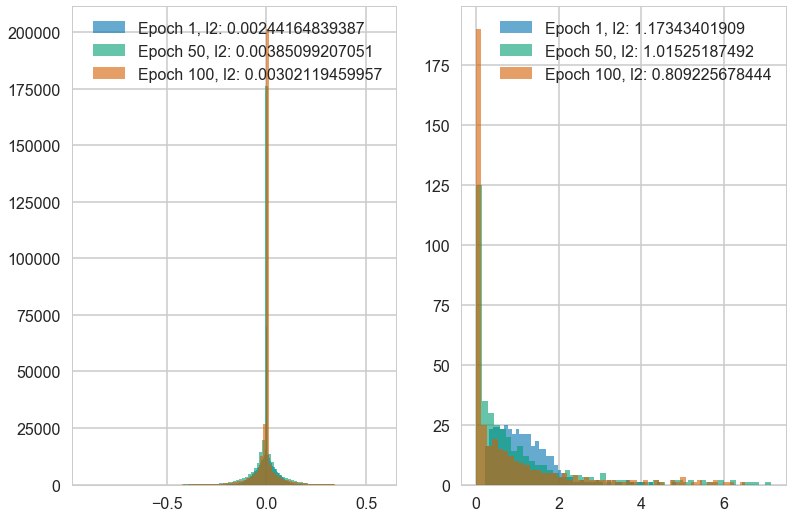

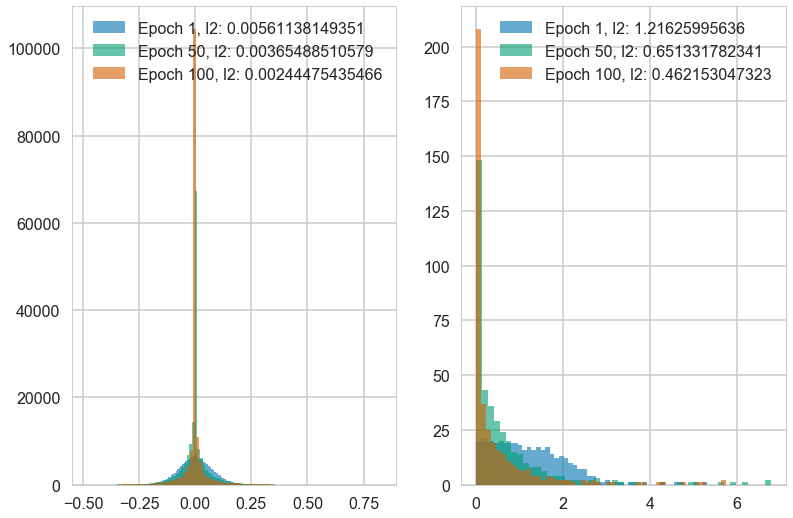

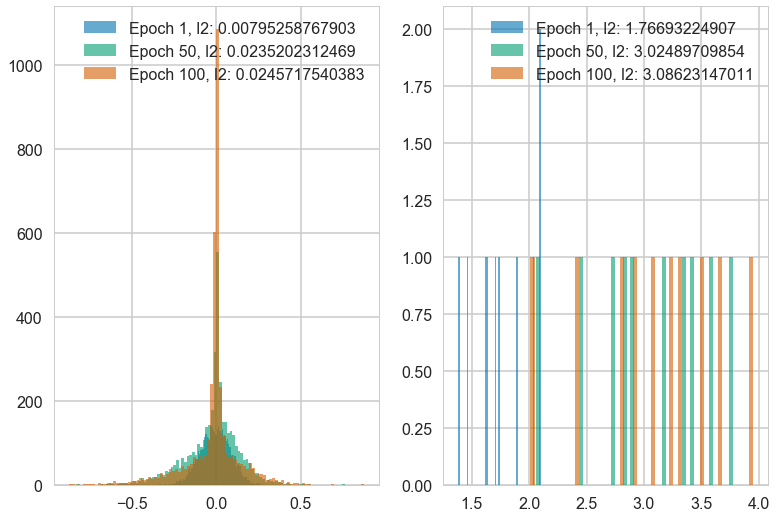

Jacobian histogram and singular values


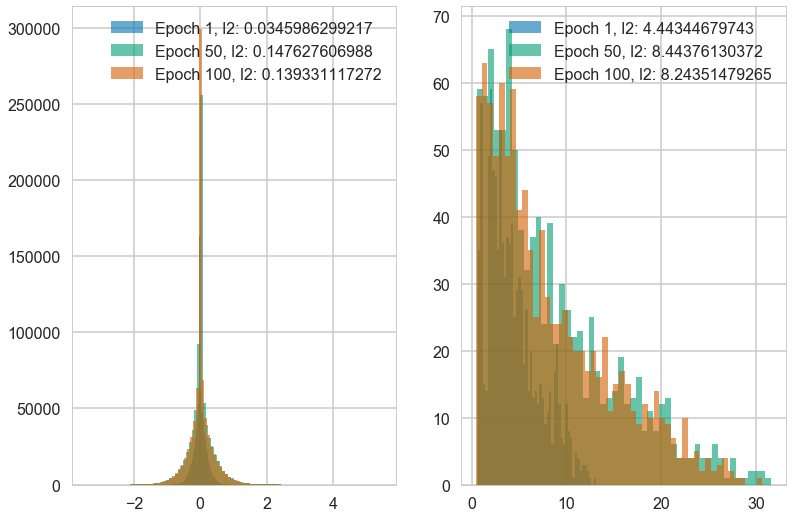

In [82]:
checkpoint1 = torch.load('/Users/christoslouizos/git/BayesianTrainingExperiments/runs/MLP_map/checkpoint_1.pth.tar')
checkpoint2 = torch.load('/Users/christoslouizos/git/BayesianTrainingExperiments/runs/MLP_map/checkpoint_50.pth.tar')
checkpoint3 = torch.load('/Users/christoslouizos/git/BayesianTrainingExperiments/runs/MLP_map/checkpoint_100.pth.tar')
model1 = MLP(784, 10, layer_dims=(400, 400), type_net='map')
model2 = MLP(784, 10, layer_dims=(400, 400), type_net='map')
model3 = MLP(784, 10, layer_dims=(400, 400), type_net='map')
model1.load_state_dict(checkpoint1['state_dict'])
model2.load_state_dict(checkpoint2['state_dict'])
model3.load_state_dict(checkpoint3['state_dict'])

weights1 = [model1.layers[0].weight.detach().numpy(), 
            model1.layers[1].weight.detach().numpy(), 
            model1.layers[2].weight.detach().numpy()]
weights2 = [model2.layers[0].weight.detach().numpy(), 
            model2.layers[1].weight.detach().numpy(), 
            model2.layers[2].weight.detach().numpy()]
weights3 = [model3.layers[0].weight.detach().numpy(), 
            model3.layers[1].weight.detach().numpy(), 
            model3.layers[2].weight.detach().numpy()]
plot_weight_stats((weights1, weights2, weights3), (1, 50, 100))

jacobian1 = compute_jacobian(input_var, model1(input_var))
jacobian2 = compute_jacobian(input_var, model2(input_var))
jacobian3 = compute_jacobian(input_var, model3(input_var))
plot_jacobian_stats((jacobian1, jacobian2, jacobian3), (1, 50, 100))

FFGaussDense (784 -> 400, prior_std: 1.0)
FFGaussDense (400 -> 400, prior_std: 1.0)
FFGaussDense (400 -> 10, prior_std: 1.0)
FFGaussDense (784 -> 400, prior_std: 1.0)
FFGaussDense (400 -> 400, prior_std: 1.0)
FFGaussDense (400 -> 10, prior_std: 1.0)
FFGaussDense (784 -> 400, prior_std: 1.0)
FFGaussDense (400 -> 400, prior_std: 1.0)
FFGaussDense (400 -> 10, prior_std: 1.0)
Layer 1, weight histogram and singular values
Layer 2, weight histogram and singular values
Layer 3, weight histogram and singular values


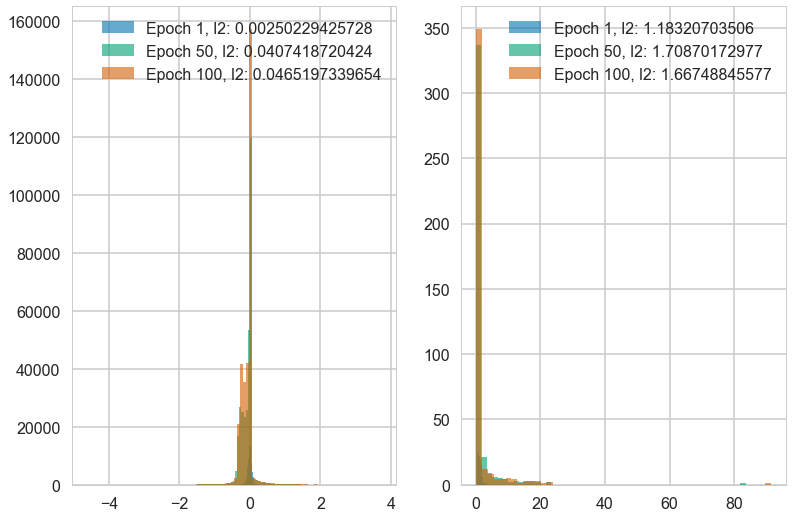

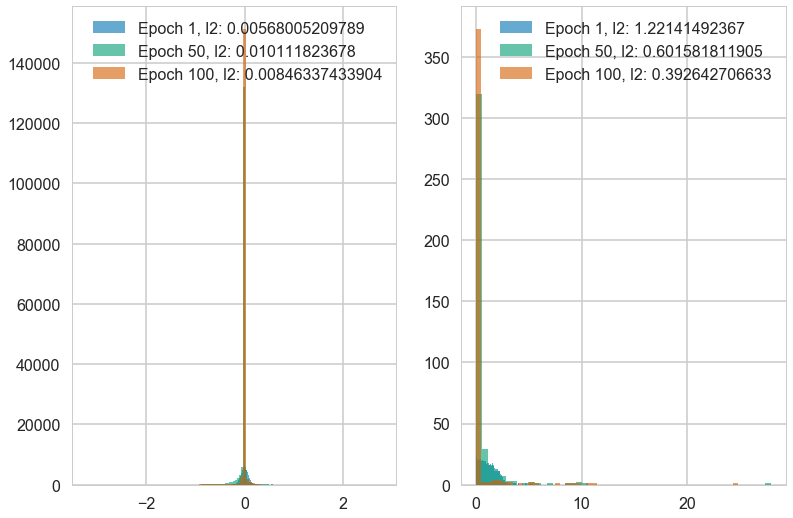

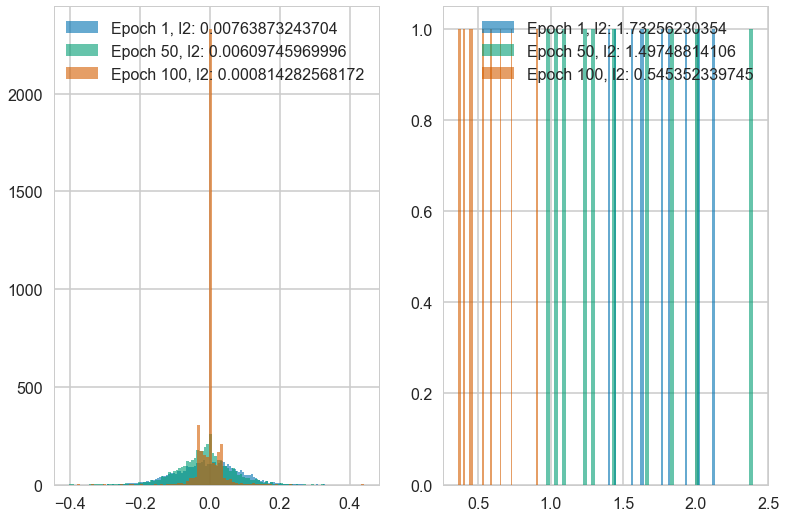

Jacobian histogram and singular values


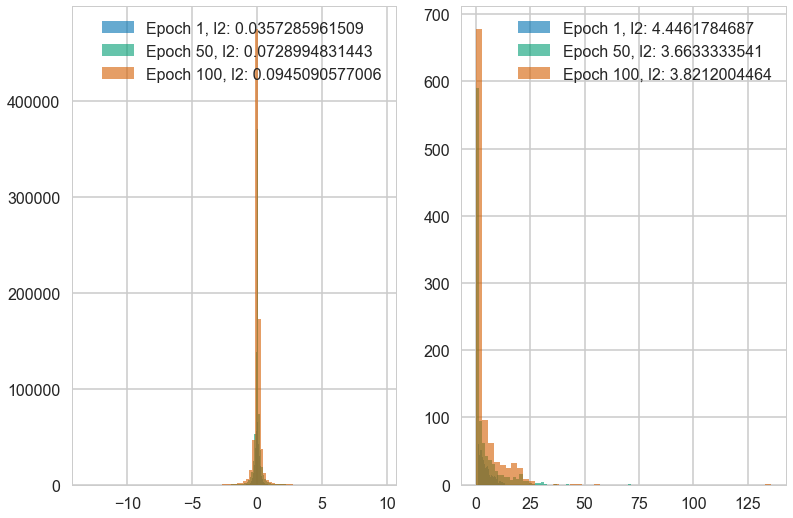

In [83]:
checkpoint1 = torch.load('/Users/christoslouizos/git/BayesianTrainingExperiments/runs/MLP_gauss/checkpoint_1.pth.tar')
checkpoint2 = torch.load('/Users/christoslouizos/git/BayesianTrainingExperiments/runs/MLP_gauss/checkpoint_50.pth.tar')
checkpoint3 = torch.load('/Users/christoslouizos/git/BayesianTrainingExperiments/runs/MLP_gauss/checkpoint_100.pth.tar')
model1 = MLP(784, 10, layer_dims=(400, 400), type_net='gauss')
model2 = MLP(784, 10, layer_dims=(400, 400), type_net='gauss')
model3 = MLP(784, 10, layer_dims=(400, 400), type_net='gauss')
model1.load_state_dict(checkpoint1['state_dict'])
model2.load_state_dict(checkpoint2['state_dict'])
model3.load_state_dict(checkpoint3['state_dict'])

weights1 = [model1.layers[0].mean_w.detach().numpy(), 
            model1.layers[1].mean_w.detach().numpy(), 
            model1.layers[2].mean_w.detach().numpy()]
weights2 = [model2.layers[0].mean_w.detach().numpy(), 
            model2.layers[1].mean_w.detach().numpy(), 
            model2.layers[2].mean_w.detach().numpy()]
weights3 = [model3.layers[0].mean_w.detach().numpy(), 
            model3.layers[1].mean_w.detach().numpy(), 
            model3.layers[2].mean_w.detach().numpy()]
plot_weight_stats((weights1, weights2, weights3), (1, 50, 100))

jacobian1 = compute_jacobian(input_var, model1(input_var))
jacobian2 = compute_jacobian(input_var, model2(input_var))
jacobian3 = compute_jacobian(input_var, model3(input_var))
plot_jacobian_stats((jacobian1, jacobian2, jacobian3), (1, 50, 100))

FFGaussDense (784 -> 400, prior_std: 1.0)
FFGaussDense (400 -> 400, prior_std: 1.0)
FFGaussDense (400 -> 10, prior_std: 1.0)
FFGaussDense (784 -> 400, prior_std: 1.0)
FFGaussDense (400 -> 400, prior_std: 1.0)
FFGaussDense (400 -> 10, prior_std: 1.0)
FFGaussDense (784 -> 400, prior_std: 1.0)
FFGaussDense (400 -> 400, prior_std: 1.0)
FFGaussDense (400 -> 10, prior_std: 1.0)
Layer 1, weight histogram and singular values
Layer 2, weight histogram and singular values
Layer 3, weight histogram and singular values


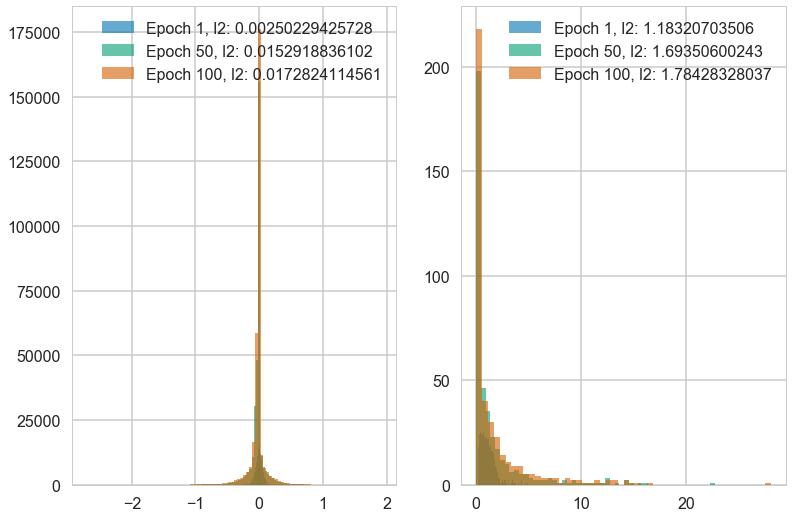

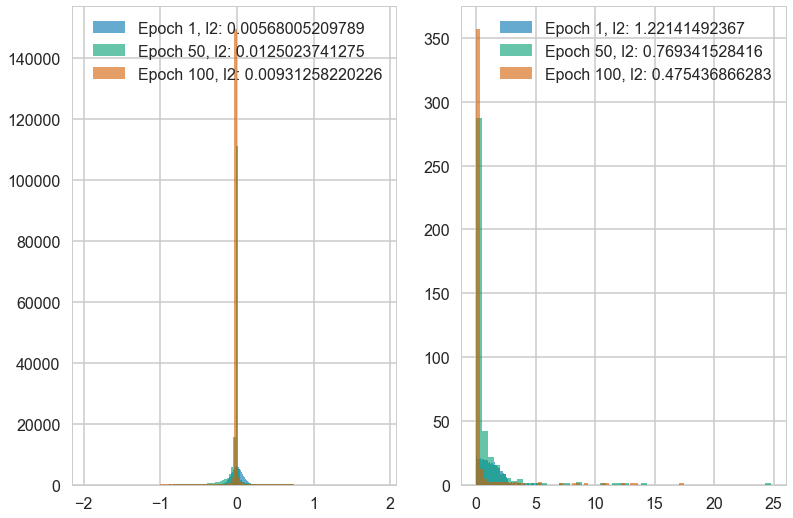

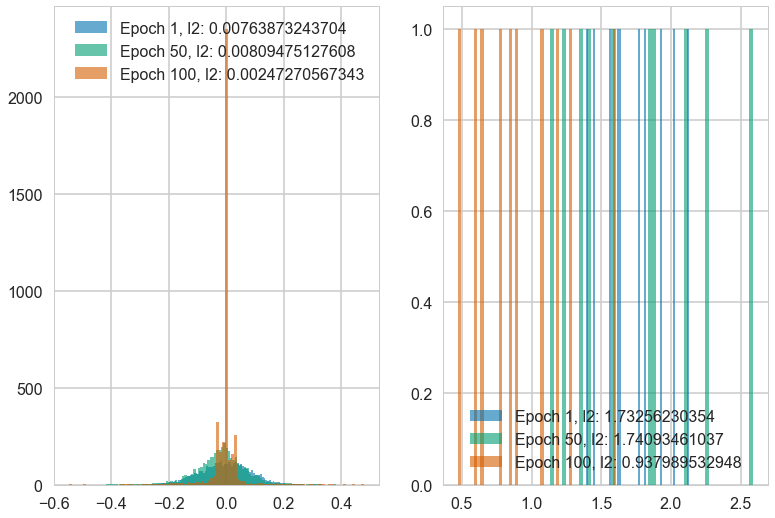

Jacobian histogram and singular values


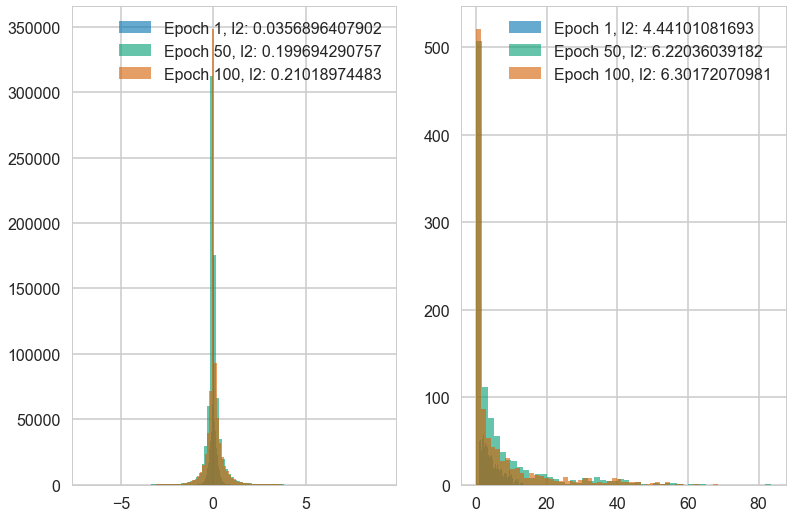

In [84]:
checkpoint1 = torch.load('/Users/christoslouizos/git/BayesianTrainingExperiments/runs/MLP_thres_gauss/checkpoint_1.pth.tar')
checkpoint2 = torch.load('/Users/christoslouizos/git/BayesianTrainingExperiments/runs/MLP_thres_gauss/checkpoint_50.pth.tar')
checkpoint3 = torch.load('/Users/christoslouizos/git/BayesianTrainingExperiments/runs/MLP_thres_gauss/checkpoint_100.pth.tar')
model1 = MLP(784, 10, layer_dims=(400, 400), type_net='gauss')
model2 = MLP(784, 10, layer_dims=(400, 400), type_net='gauss')
model3 = MLP(784, 10, layer_dims=(400, 400), type_net='gauss')
model1.load_state_dict(checkpoint1['state_dict'])
model2.load_state_dict(checkpoint2['state_dict'])
model3.load_state_dict(checkpoint3['state_dict'])

weights1 = [model1.layers[0].mean_w.detach().numpy(), 
            model1.layers[1].mean_w.detach().numpy(), 
            model1.layers[2].mean_w.detach().numpy()]
weights2 = [model2.layers[0].mean_w.detach().numpy(), 
            model2.layers[1].mean_w.detach().numpy(), 
            model2.layers[2].mean_w.detach().numpy()]
weights3 = [model3.layers[0].mean_w.detach().numpy(), 
            model3.layers[1].mean_w.detach().numpy(), 
            model3.layers[2].mean_w.detach().numpy()]
plot_weight_stats((weights1, weights2, weights3), (1, 50, 100))

jacobian1 = compute_jacobian(input_var, model1(input_var))
jacobian2 = compute_jacobian(input_var, model2(input_var))
jacobian3 = compute_jacobian(input_var, model3(input_var))
plot_jacobian_stats((jacobian1, jacobian2, jacobian3), (1, 50, 100))